# Save Directory

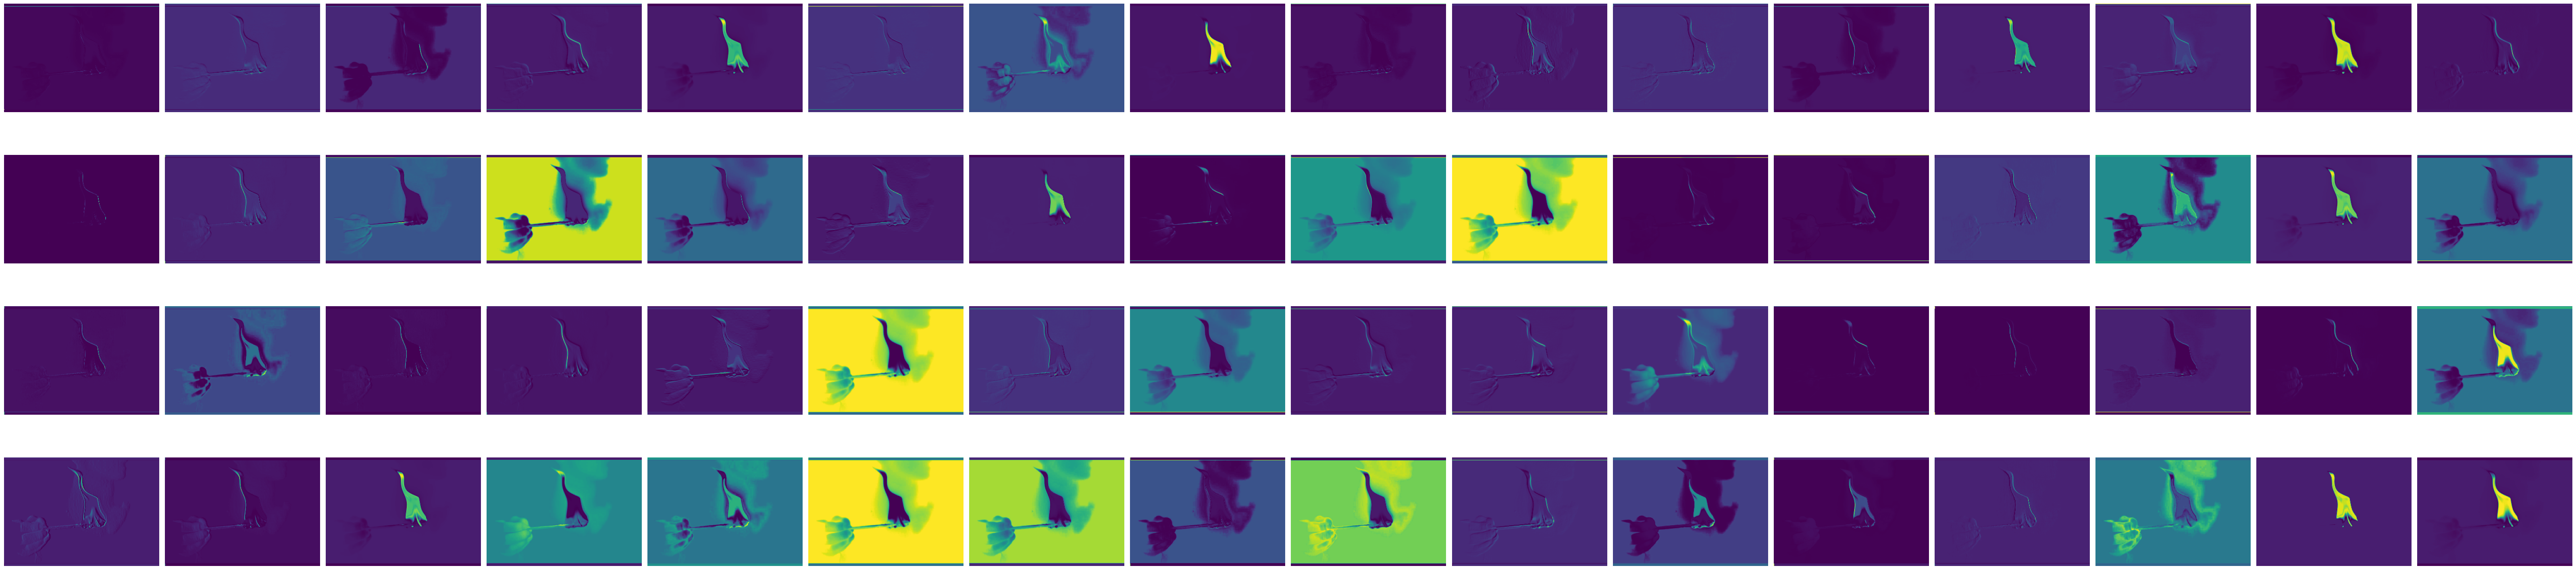

In [18]:
import numpy as np

path = r"F:\Programming\Pycod\yolov9-main\runs\detect\exp5\hand-with-burning-matchstick-453905709-5703d7365f9b581408ae9da0\stage0_Conv_features.npy"

# Load the npy file
t_np = np.load(path)

num_rows = 4 
num_cols = t_np.shape[0] // num_rows

# Calculate the size of each subplot
subplot_width = 4
subplot_height = 4

# Create a figure and axis objects
fig, axs = plt.subplots(num_rows, num_cols, figsize=(num_cols*subplot_width, num_rows*subplot_height))

# Display each image in the stack in a grid
for i in range(t_np.shape[0]):
    row = i // num_cols
    col = i % num_cols
    ax = axs[row, col]
    ax.imshow(t_np[i], cmap='viridis')
    ax.axis('off')  # Hide axes
    ax.set_aspect('equal')  # Set equal aspect ratio

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()




# First 10

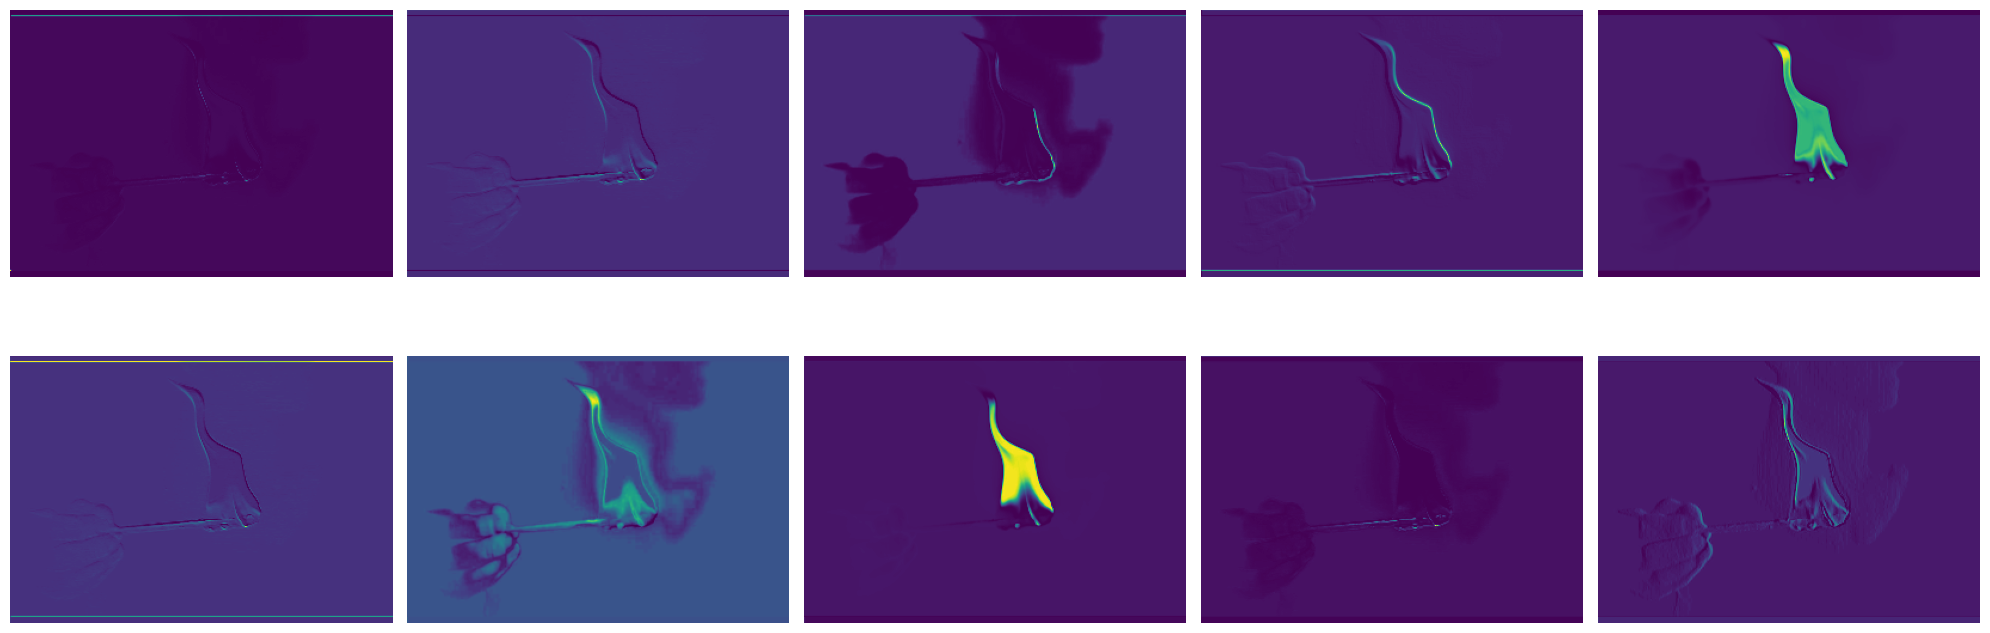

In [19]:
import numpy as np
import matplotlib.pyplot as plt

# Load the npy file
t_np = np.load(path)

# Limit the number of images to display
num_images = 10
t_np = t_np[:num_images]

num_rows = 2  # Adjust as needed
num_cols = num_images // num_rows

# Calculate the size of each subplot
subplot_width = 4
subplot_height = 4

# Create a figure and axis objects
fig, axs = plt.subplots(num_rows, num_cols, figsize=(num_cols*subplot_width, num_rows*subplot_height))

# Display each image in the stack in a grid
for i in range(num_images):
    row = i // num_cols
    col = i % num_cols
    ax = axs[row, col]
    ax.imshow(t_np[i], cmap='viridis')
    ax.axis('off')  # Hide axes
    ax.set_aspect('equal')  # Set equal aspect ratio

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


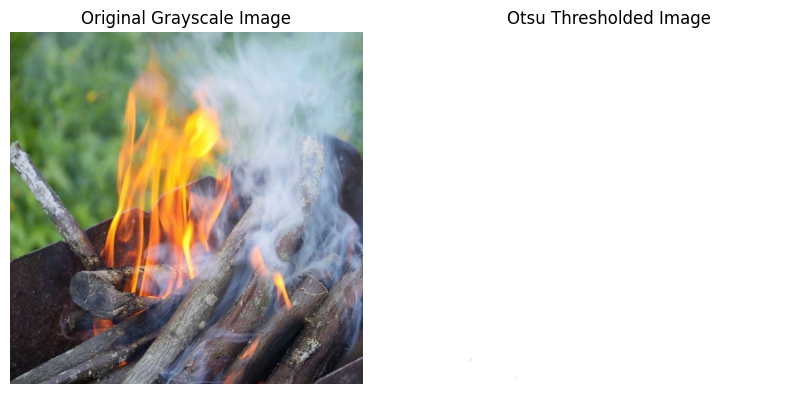

In [4]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt

class OtsuThresholding(nn.Module):
    def __init__(self):
        super(OtsuThresholding, self).__init__()

    def forward(self, x):
        # Check if input tensor has four dimensions
        if x.dim() == 4:
            # If input tensor has four dimensions, squeeze it to remove the channel dimension
            x = x.squeeze(0)
        
        # Otsu thresholding implementation
        threshold_value = self.otsu_threshold(x)
        binary_mask = torch.where(x > threshold_value, torch.tensor(255), torch.tensor(0))
        return binary_mask

    def otsu_threshold(self, x):
        # Otsu thresholding implementation
        # Normalize input image to the range [0, 1]
        x_normalized = x / 255.0

        # Compute histogram
        hist = torch.histc(x_normalized, bins=256, min=0, max=1)

        # Initialization
        var_max = 0
        threshold = 0

        # Computing the cumulative sum and cumulative mean
        cumulative_sum = torch.cumsum(hist, dim=0)
        cumulative_mean = torch.cumsum(torch.arange(256) * hist, dim=0)

        for t in range(1, 256):
            w0 = cumulative_sum[t]
            w1 = 1 - w0
            if w0 == 0 or w1 == 0:
                continue

            mean0 = cumulative_mean[t] / w0
            mean1 = (cumulative_mean[-1] - cumulative_mean[t]) / w1

            var_between = w0 * w1 * (mean0 - mean1) ** 2
            if var_between > var_max:
                var_max = var_between
                threshold = t

        return threshold / 255.0  # Return threshold value in the range [0, 1]

# Load an image
image_path = r"F:\Programming\Pycod\Yolov9_FireDet\25imgcont\nam-mo-thay-lua-3.jpg"
image = Image.open(image_path)

# Convert the image to grayscale
transform = transforms.Compose([
    transforms.Grayscale(),  # Convert to grayscale
    transforms.ToTensor()
])
input_data = transform(image).unsqueeze(0)

# Create an instance of OtsuThresholding
otsu_layer = OtsuThresholding()

# Apply Otsu thresholding
output = otsu_layer(input_data)

# Convert output tensor to image
output_image = transforms.ToPILImage()(output.byte())

# Display the original and thresholded images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')  # Display the original grayscale image
plt.title('Original Grayscale Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(output_image, cmap='gray')
plt.title('Otsu Thresholded Image')
plt.axis('off')

plt.show()


Threshold: 0.8496094


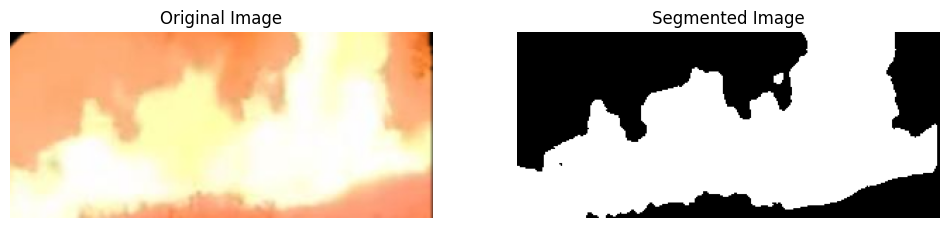

In [2]:
import torch
import torch.nn as nn
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from skimage.filters import threshold_otsu
import numpy as np

class OtsuSegmentation(nn.Module):
    def __init__(self, num_classes):
        super(OtsuSegmentation, self).__init__()
        self.num_classes = num_classes

    def forward(self, x):
        # Convert to grayscale
        x_gray = x.mean(dim=1, keepdim=True)

        # Apply Otsu thresholding
        for i in range(x_gray.size(0)):
            threshold = threshold_otsu(x_gray[i].detach().cpu().numpy())
            print("Threshold:", threshold)  # Debug: Print threshold value
            x_gray[i] = (x_gray[i] > threshold).float()

        return x_gray

# Load the image
image_path = r"F:\Screenshot 2024-03-28 103913.png"  # Update with the correct path to your image
image = Image.open(image_path)

# Define transformations
transform = transforms.Compose([
    transforms.Grayscale(),  # Convert image to grayscale
    transforms.ToTensor(),   # Convert PIL image to tensor
])

# Apply transformations
input_tensor = transform(image).unsqueeze(0)  # Add batch dimension

# Initialize and load the model
num_classes = 1  # Otsu segmentation yields binary mask
model = OtsuSegmentation(num_classes)

# Apply the model to the input tensor
segmented_tensor = model(input_tensor)

# Convert the segmented tensor back to an image
segmented_image = transforms.ToPILImage()(segmented_tensor.squeeze(0))

# Display the original and segmented images
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(image, cmap='gray')  # Show the original image in grayscale
axes[0].set_title('Original Image')
axes[0].axis('off')
axes[1].imshow(segmented_image, cmap='gray')  # Show the segmented image in grayscale
axes[1].set_title('Segmented Image')
axes[1].axis('off')
plt.show()
